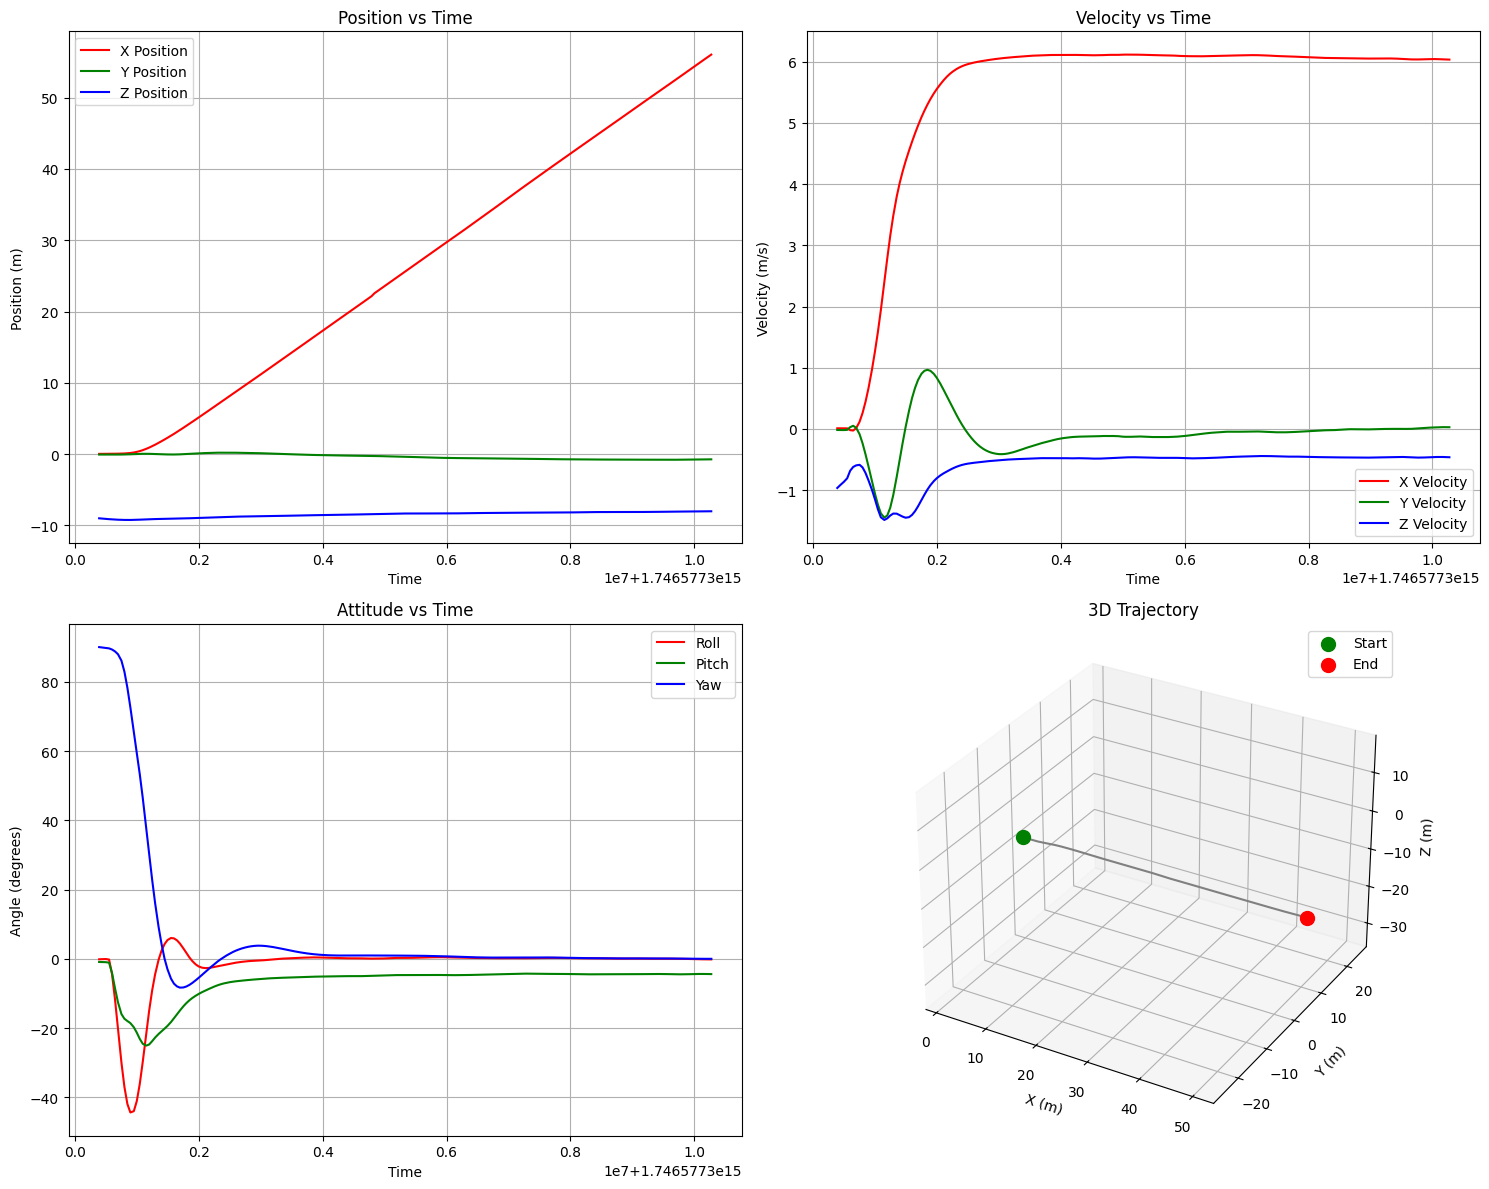

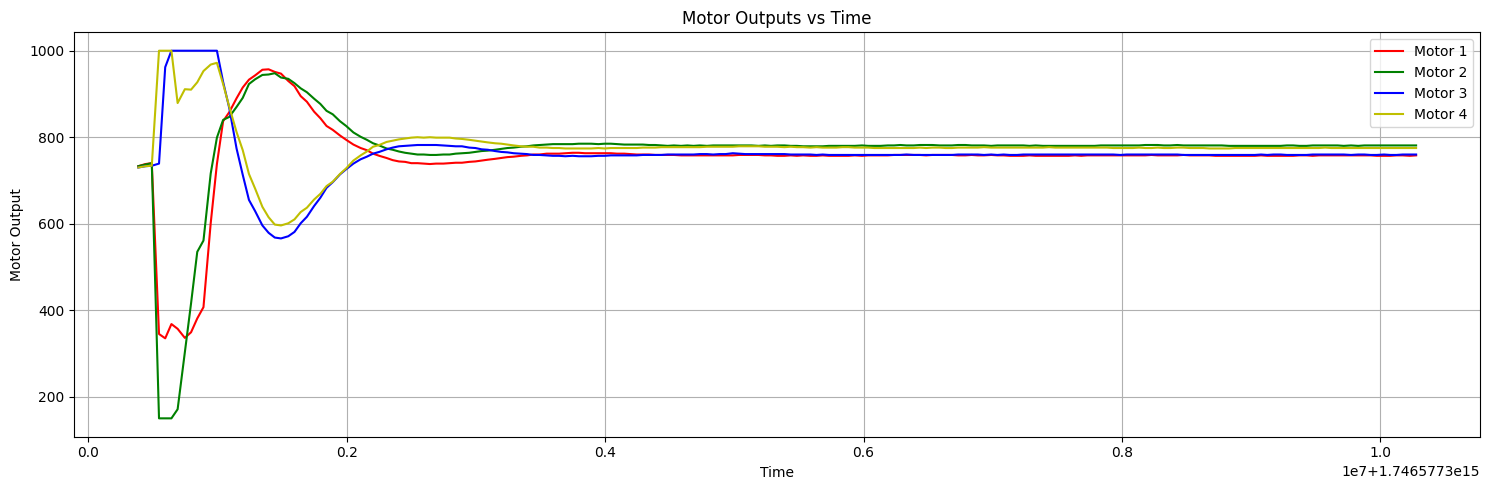

In [3]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('/home/eashan/workspace/DreamingFalconROS/flight_logs/flight_data_20250506-202140.csv')

# Access the data
positions = df[['x', 'y', 'z']].values
velocities = df[['vx', 'vy', 'vz']].values
attitudes = df[['roll', 'pitch', 'yaw']].values

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Check if there's a timestamp column, otherwise create one
if 'timestamp' in df.columns:
    time_data = df['timestamp'].values
else:
    time_data = np.arange(len(df))

# Create 4 subplots in a 2x2 grid
fig = plt.figure(figsize=(15, 12))

# 1. Position plot
ax1 = fig.add_subplot(221)
ax1.plot(time_data, df['x'], 'r-', label='X Position')
ax1.plot(time_data, df['y'], 'g-', label='Y Position')
ax1.plot(time_data, df['z'], 'b-', label='Z Position')
ax1.set_title('Position vs Time')
ax1.set_xlabel('Time')
ax1.set_ylabel('Position (m)')
ax1.grid(True)
ax1.legend()

# 2. Velocity plot
ax2 = fig.add_subplot(222)
ax2.plot(time_data, df['vx'], 'r-', label='X Velocity')
ax2.plot(time_data, df['vy'], 'g-', label='Y Velocity')
ax2.plot(time_data, df['vz'], 'b-', label='Z Velocity')
ax2.set_title('Velocity vs Time')
ax2.set_xlabel('Time')
ax2.set_ylabel('Velocity (m/s)')
ax2.grid(True)
ax2.legend()

# 3. Attitude plot
ax3 = fig.add_subplot(223)
ax3.plot(time_data, np.degrees(df['roll']), 'r-', label='Roll')
ax3.plot(time_data, np.degrees(df['pitch']), 'g-', label='Pitch')
ax3.plot(time_data, np.degrees(df['yaw']), 'b-', label='Yaw')
ax3.set_title('Attitude vs Time')
ax3.set_xlabel('Time')
ax3.set_ylabel('Angle (degrees)')
ax3.grid(True)
ax3.legend()

# 4. 3D trajectory plot
ax4 = fig.add_subplot(224, projection='3d')
ax4.plot3D(df['x'], df['y'], df['z'], 'gray')
ax4.scatter(df['x'].iloc[0], df['y'].iloc[0], df['z'].iloc[0], 
           color='green', marker='o', s=100, label='Start')
ax4.scatter(df['x'].iloc[-1], df['y'].iloc[-1], df['z'].iloc[-1], 
           color='red', marker='o', s=100, label='End')
ax4.set_title('3D Trajectory')
ax4.set_xlabel('X (m)')
ax4.set_ylabel('Y (m)')
ax4.set_zlabel('Z (m)')
ax4.legend()

# Make the axes equal for the 3D plot to avoid distortion
max_range = max(
    np.ptp(df['x']), 
    np.ptp(df['y']), 
    np.ptp(df['z'])
)
mid_x = np.mean(df['x'])
mid_y = np.mean(df['y'])
mid_z = np.mean(df['z'])
ax4.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
ax4.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
ax4.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

plt.tight_layout()
plt.show()

# Additionally, let's create plots for the motor outputs
plt.figure(figsize=(15, 5))
plt.plot(time_data, df['motor1'], 'r-', label='Motor 1')
plt.plot(time_data, df['motor2'], 'g-', label='Motor 2')
plt.plot(time_data, df['motor3'], 'b-', label='Motor 3')
plt.plot(time_data, df['motor4'], 'y-', label='Motor 4')
plt.title('Motor Outputs vs Time')
plt.xlabel('Time')
plt.ylabel('Motor Output')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
import torch
from models import WorldModel
from utils import AttrDict
import yaml
import numpy as np
import matplotlib.pyplot as plt

# Normalization factors
position_norm_factor = 1.0  # 25.0
velocity_norm_factor = 1.0  # 12.0

def normalize_state(state):
    normalized = state.copy()
    normalized[0:3] /= position_norm_factor
    normalized[3:6] /= velocity_norm_factor
    return normalized

def denormalize_state(state):
    denormalized = state.copy()
    denormalized[0:3] *= position_norm_factor
    denormalized[3:6] *= velocity_norm_factor
    return denormalized

# Load model
with open("/home/eashan/workspace/DreamingFalconROS/config.yaml") as f:
    config = AttrDict.from_dict(yaml.safe_load(f))
device = torch.device(config.device)
world_model = WorldModel(config, device).to(device)
chk = torch.load("/home/eashan/workspace/DreamingFalconROS/models/run_0/model.pt", map_location=device)
world_model.load_state_dict(chk["state_dict"])
world_model.eval()

start_point = 0
end_point = 32

# Prepare data
dts = df['dt'].values.astype(np.float32)
acts = df[['motor1','motor2','motor3','motor4']].values.astype(np.float32)
states = df[['x','y','z','vx','vy','vz',
             'roll','pitch','yaw',
             'roll_rate','pitch_rate','yaw_rate']].values.astype(np.float32)

normalized_states = np.apply_along_axis(normalize_state, 1, states)

with torch.no_grad():
    dts_t = torch.from_numpy(dts).to(device).unsqueeze(0)
    acts_t = torch.from_numpy(acts).to(device).unsqueeze(0)
    sts_t = torch.from_numpy(normalized_states).to(device).unsqueeze(0)

    rollout = world_model.rollout(
        dts_t[:, start_point:end_point],
        sts_t[:, start_point, :],
        acts_t[:, start_point:end_point, :]
    )
    pred = rollout.squeeze(0).cpu().numpy()
    pred = denormalize_state(pred)

actual = states
time_data = df['timestamp'].values

# --- Combined subplots (you already have this) ---
plt.figure(figsize=(20, 15))
# ... your existing 3×4 subplot code ...
plt.tight_layout()
plt.show()


# --- Four summary plots ---

print(f"Actual Shape: {actual.shape}")

# 1) Position summary
plt.figure(figsize=(10, 6))
for i, (axis, color) in enumerate(zip(['x','y','z'], ['r','g','b'])):
    plt.plot(time_data[start_point:end_point], actual[start_point:end_point, i],     f'{color}-',  label=f'Actual {axis}')
    plt.plot(time_data[start_point:end_point], pred[:, i],                  f'{color}--', label=f'Pred {axis}')
plt.title('Position (m)')
plt.xlabel('Time')
plt.ylabel('Position')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 2) Velocity summary
plt.figure(figsize=(10, 6))
for i, (axis, color) in enumerate(zip(['vx','vy','vz'], ['r','g','b'])):
    plt.plot(time_data[start_point:end_point], actual[start_point:end_point, i+3],   f'{color}-',  label=f'Actual {axis}')
    plt.plot(time_data[start_point:end_point], pred[:, i+3],               f'{color}--', label=f'Pred {axis}')
plt.title('Velocity (m/s)')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 3) Attitude summary (degrees)
plt.figure(figsize=(10, 6))
for i, (axis, color) in enumerate(zip(['roll','pitch','yaw'], ['r','g','b'])):
    plt.plot(time_data[start_point:end_point], np.degrees(actual[start_point:end_point, i+6]), f'{color}-',  label=f'Actual {axis}')
    plt.plot(time_data[start_point:end_point], np.degrees(pred[:, i+6]),             f'{color}--', label=f'Pred {axis}')
plt.title('Attitude (°)')
plt.xlabel('Time')
plt.ylabel('Angle')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 4) Angular velocity summary
plt.figure(figsize=(10, 6))
for i, (axis, color) in enumerate(zip(['roll_rate','pitch_rate','yaw_rate'], ['r','g','b'])):
    plt.plot(time_data[start_point:end_point], actual[start_point:end_point, i+9],   f'{color}-',  label=f'Actual {axis}')
    plt.plot(time_data[start_point:end_point], pred[:, i+9],               f'{color}--', label=f'Pred {axis}')
plt.title('Angular Velocity (rad/s)')
plt.xlabel('Time')
plt.ylabel('Rate')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


RuntimeError: Error(s) in loading state_dict for WorldModel:
	Missing key(s) in state_dict: "model.network.0.weight", "model.network.0.bias", "model.network.3.weight", "model.network.3.bias", "model.network.6.weight", "model.network.6.bias". 
	Unexpected key(s) in state_dict: "rnn.cells.weight_ih_l0", "rnn.cells.weight_hh_l0", "rnn.cells.bias_ih_l0", "rnn.cells.bias_hh_l0", "rnn.cells.weight_ih_l1", "rnn.cells.weight_hh_l1", "rnn.cells.bias_ih_l1", "rnn.cells.bias_hh_l1", "rnn.cells.weight_ih_l2", "rnn.cells.weight_hh_l2", "rnn.cells.bias_ih_l2", "rnn.cells.bias_hh_l2", "rnn.cells.weight_ih_l3", "rnn.cells.weight_hh_l3", "rnn.cells.bias_ih_l3", "rnn.cells.bias_hh_l3", "rnn.cells.weight_ih_l4", "rnn.cells.weight_hh_l4", "rnn.cells.bias_ih_l4", "rnn.cells.bias_hh_l4", "rnn.cells.weight_ih_l5", "rnn.cells.weight_hh_l5", "rnn.cells.bias_ih_l5", "rnn.cells.bias_hh_l5", "rnn.cells.weight_ih_l6", "rnn.cells.weight_hh_l6", "rnn.cells.bias_ih_l6", "rnn.cells.bias_hh_l6", "rnn.cells.weight_ih_l7", "rnn.cells.weight_hh_l7", "rnn.cells.bias_ih_l7", "rnn.cells.bias_hh_l7", "rnn.fc.weight", "rnn.fc.bias", "h0_encoder.weight_ih_l0", "h0_encoder.weight_hh_l0", "h0_encoder.bias_ih_l0", "h0_encoder.bias_hh_l0", "h0_encoder.weight_ih_l1", "h0_encoder.weight_hh_l1", "h0_encoder.bias_ih_l1", "h0_encoder.bias_hh_l1", "h0_encoder.weight_ih_l2", "h0_encoder.weight_hh_l2", "h0_encoder.bias_ih_l2", "h0_encoder.bias_hh_l2", "h0_encoder.weight_ih_l3", "h0_encoder.weight_hh_l3", "h0_encoder.bias_ih_l3", "h0_encoder.bias_hh_l3", "h0_encoder.weight_ih_l4", "h0_encoder.weight_hh_l4", "h0_encoder.bias_ih_l4", "h0_encoder.bias_hh_l4", "h0_encoder.weight_ih_l5", "h0_encoder.weight_hh_l5", "h0_encoder.bias_ih_l5", "h0_encoder.bias_hh_l5", "h0_encoder.weight_ih_l6", "h0_encoder.weight_hh_l6", "h0_encoder.bias_ih_l6", "h0_encoder.bias_hh_l6", "h0_encoder.weight_ih_l7", "h0_encoder.weight_hh_l7", "h0_encoder.bias_ih_l7", "h0_encoder.bias_hh_l7". 